In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [119]:
Y_MIN = 20.
Y_MAX = 400-20.
X_MIN = Y_MIN
X_MAX = Y_MAX
SCALE_FP = 100*100
BALL_R = 20
R2SQ = 1600 #(R+R)**2
A_FRICTION = 30

SCORE_S1 = 10
SCORE_S2 = 15
SCORE_S3 = 20

NAMES = ['s1', 's2', 's3', 'fb', 'pl']

In [120]:
def euler_collision_friction (dt, system_states, first):
    
    ## TODO: consider implementing adaptive euler for potential efficiency gain
    ## i.e. smaller dt at high velocity
    
    # Euler step (boundary collision handled)
    system_states_cand = {}
    collided_with_boundary_s = {}
    for name in NAMES:
        system_states_cand[name], collided_with_boundary_s[name] = euler_single_step (dt, system_states[name])
    
    # expand dictionary
    s1 = system_states['s1']
    s2 = system_states['s2']
    s3 = system_states['s3']
    fb = system_states['fb']
    pl = system_states['pl']
    s1_cand = system_states_cand['s1']
    s2_cand = system_states_cand['s2']
    s3_cand = system_states_cand['s3']
    fb_cand = system_states_cand['fb']
    pl_cand = system_states_cand['pl']
    
    # Handle circle-circle collision
    # s1, s2, s3
    s1_nxt_, s2_nxt_, s1_s2_has_collided = collision_pair_circles (s1, s2, s1_cand, s2_cand)
    s2_nxt__, s3_nxt_, s2_s3_has_collided = collision_pair_circles (s2, s3, s2_nxt_, s3_cand)
    s1_nxt__, s3_nxt__, s1_s3_has_collided = collision_pair_circles (s1, s3, s1_nxt_, s3_nxt_)

    # s1, fb
    s1_nxt___, fb_nxt_, s1_fb_has_collided = collision_pair_circles (s1, fb, s1_nxt__, fb_cand)

    # s1, pl
    s1_nxt____, pl_nxt_, s1_pl_has_collided = collision_pair_circles (s1, pl, s1_nxt___, pl_cand)

    # s2, fb
    s2_nxt___, fb_nxt__, s2_fb_has_collided = collision_pair_circles (s2, fb, s2_nxt__, fb_nxt_)

    # s2, pl
    s2_nxt____, pl_nxt__, s2_pl_has_collided = collision_pair_circles (s2, pl, s2_nxt___, pl_nxt_)

    # s3, fb
    s3_nxt___, fb_nxt___, s3_fb_has_collided = collision_pair_circles (s3, fb, s3_nxt__, fb_nxt__)

    # s3, pl
    s3_nxt____, pl_nxt___, s3_pl_has_collided = collision_pair_circles (s3, pl, s3_nxt___, pl_nxt__)

    # fb, pl
    fb_nxt____, pl_nxt____, fb_pl_has_collided = collision_pair_circles (fb, pl, fb_nxt___, pl_nxt___)

    
    # Handle friction
    sum_s1_bools = first + collided_with_boundary_s['s1'] + s1_s2_has_collided + s1_s3_has_collided + s1_fb_has_collided + s1_pl_has_collided
    s1_should_recalc_friction = sum_s1_bools != 0
    s1_final = friction_single_circle (dt=dt, state=s1_nxt____, should_recalc=s1_should_recalc_friction)
    
    sum_s2_bools = first + collided_with_boundary_s['s2'] + s1_s2_has_collided + s2_s3_has_collided + s2_fb_has_collided + s2_pl_has_collided
    s2_should_recalc_friction = sum_s2_bools != 0
    s2_final = friction_single_circle (dt=dt, state=s2_nxt____, should_recalc=s2_should_recalc_friction)
    
    sum_s3_bools = first + collided_with_boundary_s['s3'] + s1_s3_has_collided + s2_s3_has_collided + s3_fb_has_collided + s3_pl_has_collided
    s3_should_recalc_friction = sum_s3_bools != 0
    s3_final = friction_single_circle (dt=dt, state=s3_nxt____, should_recalc=s3_should_recalc_friction)
    
    sum_fb_bools = first + collided_with_boundary_s['fb'] + s1_fb_has_collided + s2_fb_has_collided + s3_fb_has_collided + fb_pl_has_collided
    fb_should_recalc_friction = sum_fb_bools != 0
    fb_final = friction_single_circle (dt=dt, state=fb_nxt____, should_recalc=fb_should_recalc_friction)
    
    sum_pl_bools = first + collided_with_boundary_s['pl'] + s1_pl_has_collided + s2_pl_has_collided + s3_pl_has_collided + fb_pl_has_collided
    pl_should_recalc_friction = sum_pl_bools != 0
    pl_final = friction_single_circle (dt=dt, state=pl_nxt____, should_recalc=pl_should_recalc_friction)
    
    ## Packing
    system_states_nxt = {
        's1' : s1_final,
        's2' : s2_final,
        's3' : s3_final,
        'fb' : fb_final,
        'pl' : pl_final
    }
    
    sum_illegal_bools = s1_fb_has_collided + s2_fb_has_collided + s3_fb_has_collided + fb_pl_has_collided
    broke_the_law = sum_illegal_bools != 0
    scored_s1 = s1_pl_has_collided
    scored_s2 = s2_pl_has_collided
    scored_s3 = s3_pl_has_collided
    
    return system_states_nxt, broke_the_law, scored_s1, scored_s2, scored_s3
    

In [121]:
def euler_single_step (dt, state):
    x_cand = state['x'] + state['vx']*dt
    y_cand = state['y'] + state['vy']*dt
    
    collided = False
    if x_cand < X_MIN:
        x_cand = X_MIN
        vx_cand = -state['vx']
        collided = True
    elif x_cand > X_MAX:
        x_cand = X_MAX
        vx_cand = -state['vx']
        collided = True
    else:
        vx_cand = state['vx']
        
    if y_cand < Y_MIN:
        y_cand = Y_MIN
        vy_cand = -state['vy']
        collided = True
    elif y_cand > Y_MAX:
        y_cand = Y_MAX
        vy_cand = -state['vy']
        collided = True
    else:
        vy_cand = state['vy']
    
    state_cand = {
        'x' : x_cand,
        'y' : y_cand,
        'vx' : vx_cand,
        'vy' : vy_cand,
        'ax' : state['ax'],
        'ay' : state['ay']
    }
    
    return state_cand, collided

In [154]:
def collision_pair_circles (state1, state2, state1_cand, state2_cand):
    
    d_cand_sq = (state1_cand['x']-state2_cand['x'])**2 + (state1_cand['y']-state2_cand['y'])**2
    collided = d_cand_sq < R2SQ
    
    if not collided:
        state1_nxt = state1_cand
        state2_nxt = state2_cand
    else:
        print('collided!!')
        d_cand = math.sqrt(d_cand_sq)
        d = math.sqrt( (state1['x']-state2['x'])**2 + (state1['y']-state2['y'])**2 )
        nom = BALL_R + BALL_R - d_cand
        denom = d - d_cand
        
        x1_subtract = nom*(state1_cand['x']-state1['x'])/denom
        x1_nxt = state1_cand['x'] - x1_subtract
        
        y1_subtract = nom*(state1_cand['y']-state1['y'])/denom
        y1_nxt = state1_cand['y'] - y1_subtract
        
        x2_subtract = nom*(state2_cand['x']-state2['x'])/denom
        x2_nxt = state2_cand['x'] - x2_subtract
        
        y2_subtract = nom*(state2_cand['y']-state2['y'])/denom
        y2_nxt = state2_cand['y'] - y2_subtract
        
        # Vector form (source: https://en.wikipedia.org/wiki/Elastic_collision):
        #   alpha = ( (vx2-vx1, vy2-vy1) dot (x2_nxt-x1_nxt, y2_nxt-y1_nxt) ) / (r2_nxt-r1_nxt)^2
        #   (vx1_nxt, vy1_nxt) = (vx1, vy1) - alpha*(x1_nxt-x2_nxt, y1_nxt-y2_nxt)
        #   (vx2_nxt, vy2_nxt) = (vx2, vy2) - alpha*(x2_nxt-x1_nxt, y2_nxt-y1_nxt)
        vx1 = state1['vx']
        vy1 = state1['vy']
        vx2 = state2['vx']
        vy2 = state2['vy']
        alpha = ( (vx2-vx1)*(x2_nxt-x1_nxt) + (vy2-vy1)*(y2_nxt-y1_nxt) ) / ( (x2_nxt-x1_nxt)**2 + (y2_nxt-y1_nxt)**2 )
        vx1_nxt = vx1 - alpha*(x1_nxt-x2_nxt)
        vy1_nxt = vy1 - alpha*(y1_nxt-y2_nxt)
        vx2_nxt = vx2 - alpha*(x2_nxt-x1_nxt)
        vy2_nxt = vy2 - alpha*(y2_nxt-y1_nxt)
        
        #vx1_nxt = state2['vx']
        #vy1_nxt = state2['vy']
        #vx2_nxt = state1['vx']
        #vy2_nxt = state1['vy']
        
        state1_nxt = {'x':x1_nxt, 'y':y1_nxt, 'vx':vx1_nxt, 'vy':vy1_nxt, 'ax':state1['ax'], 'ay':state1['ay']}
        state2_nxt = {'x':x2_nxt, 'y':y2_nxt, 'vx':vx2_nxt, 'vy':vy2_nxt, 'ax':state2['ax'], 'ay':state2['ay']}
        
    return state1_nxt, state2_nxt, collided

In [155]:
def friction_single_circle (dt, state, should_recalc):
    
    if not should_recalc:
        ax_dt = state['ax']*dt
        ax_dt_abs = abs(ax_dt)
        vx_abs = abs(state['vx'])
        bool_x_stopped = vx_abs < ax_dt_abs
        if bool_x_stopped:
            vx_nxt = 0
            ax_nxt = 0
        else:
            vx_nxt = state['vx'] - ax_dt
            ax_nxt = state['ax']
            
        ay_dt = state['ay']*dt
        ay_dt_abs = abs(ay_dt)
        vy_abs = abs(state['vy'])
        bool_y_stopped = vy_abs < ay_dt_abs
        if bool_y_stopped:
            vy_nxt = 0
            ay_nxt = 0
        else:
            vy_nxt = state['vy'] - ay_dt
            ay_nxt = state['ay']
            
    else: # recalc
        v = math.sqrt( state['vx']**2 + state['vy']**2 )
        if v==0:
            ax_nxt = 0
            ay_nxt = 0
            ax_dt = 0
            ay_dt = 0
        else:
            ax_nxt = A_FRICTION * state['vx'] / v
            ax_dt = ax_nxt * dt
            ay_nxt = A_FRICTION * state['vy'] / v
            ay_dt = ay_nxt * dt
        
        ax_dt_abs = abs(ax_dt)
        vx_abs = abs(state['vx'])
        bool_x_stopped = vx_abs < ax_dt_abs
        if bool_x_stopped:
            vx_nxt = 0
            #ax_nxt = 0
        else:
            vx_nxt = state['vx'] - ax_dt
        
        ay_dt_abs = abs(ay_dt)
        vy_abs = abs(state['vy'])
        bool_y_stopped = vy_abs < ay_dt_abs
        if bool_y_stopped:
            vy_nxt = 0
            #ay_nxt = 0
        else:
            vy_nxt = state['vy'] - ay_dt
        
    state_nxt = {'x':state['x'], 'y':state['y'], 'vx':vx_nxt, 'vy':vy_nxt, 'ax':ax_nxt, 'ay':ay_nxt}
    
    return state_nxt

In [160]:
def run_simulation_til_stop (dt, system_states_init):
    
    n_steps = 0
    sum_broke_the_law = 0
    sum_scored_s1 = 0
    sum_scored_s2 = 0
    sum_scored_s3 = 0
    system_states = system_states_init
    first = 1
    while(True):
        system_states_nxt, broke_the_law, scored_s1, scored_s2, scored_s3 = euler_collision_friction (dt, system_states, first)
        #for k in system_states_nxt:
        #    print(k, system_states_nxt[k])
        #print()
        
        sum_broke_the_law += broke_the_law
        sum_scored_s1 += scored_s1
        sum_scored_s2 += scored_s2
        sum_scored_s3 += scored_s3
        n_steps += 1
        system_states = system_states_nxt
        first = 0
        
        bool_stopped = True
        for name in NAMES:
            bool_stopped &= (system_states[name]['vx']==0)
            bool_stopped &= (system_states[name]['vy']==0)
        
        bool_stopped = n_steps==8
        
        if bool_stopped:
            
            # calculate score
            if sum_broke_the_law != 0:
                score = 0
            else:
                score = sum_scored_s1 * SCORE_S1 + sum_scored_s2 * SCORE_S2 + sum_scored_s3 * SCORE_S3
            break
            
        else:
            continue
    
    return system_states, n_steps, score


### run simulation

In [162]:
pl_vx = 210
pl_vy = 240

system_states_init = {
    's1' : {'x':300, 'y':250, 'vx':0, 'vy':0, 'ax':0, 'ay':0},
    's2' : {'x':200, 'y':250, 'vx':0, 'vy':0, 'ax':0, 'ay':0},
    's3' : {'x':100, 'y':250, 'vx':0, 'vy':0, 'ax':0, 'ay':0},
    'fb' : {'x':200, 'y':350, 'vx':0, 'vy':0, 'ax':0, 'ay':0},
    'pl' : {'x':200, 'y':100, 'vx':pl_vx, 'vy':pl_vy, 'ax':0, 'ay':0}
}

dt = 0.1
system_states_final, n_steps, score = run_simulation_til_stop(dt, system_states_init)
for k in system_states_final:
    print(k,system_states_final[k])
print(f'n_steps: {n_steps}')
print(f'score: {score}')

collided!!
s1 {'x': 305.4695312569561, 'y': 321.69365556640014, 'vx': 17.775355283002025, 'vy': 232.99623667187237, 'ax': 2.282077867590998, 'ay': 29.913076080641577}
s2 {'x': 200.0, 'y': 250.0, 'vx': 0.0, 'vy': 0.0, 'ax': 0, 'ay': 0}
s3 {'x': 100.0, 'y': 250.0, 'vx': 0.0, 'vy': 0.0, 'ax': 0, 'ay': 0}
fb {'x': 200.0, 'y': 350.0, 'vx': 0.0, 'vy': 0.0, 'ax': 0, 'ay': 0}
pl {'x': 350.24323833905856, 'y': 206.81360320699804, 'vx': 171.44452784328277, 'vy': -13.079556293575052, 'ax': 29.91307608064158, 'ay': -2.2820778675910027}
n_steps: 8
score: 10


In [15]:
# Running a small integration
dt = 0.04

state_0 = {
    'x'  : 0,
    'vx' : 200,
    'y'  : 100,
    'vy' : 10
}

history = [state_0]
ts = [0]

N_STEP = 300
for i in range(N_STEP):
    t = ts[-1]
    state_nxt = euler_gravity (dt, history[-1])
    history.append(state_nxt)
    
    t += dt
    ts.append(t)
    
history = np.array(history)
ts = np.array(ts)

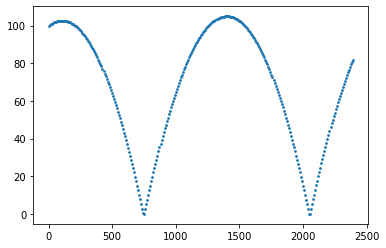

"\ncamera = Camera(plt.figure())\nfor i in range(N_STEP):\n    plt.scatter(history[i]['x'], 10, color='C0', s=3, label='x position')\n    plt.xticks(np.arange(-120, 120, 20))\n    plt.yticks(np.arange(0, 20, 5))\n    plt.grid()\n    camera.snap()\nanim = camera.animate(blit=True)\nanim.save('scatter.mp4')\n"

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera

for i in range(N_STEP):
    plt.scatter(history[i]['x'], history[i]['y'], color='C0', s=3, label='x position')
plt.show();

'''
camera = Camera(plt.figure())
for i in range(N_STEP):
    plt.scatter(history[i]['x'], 10, color='C0', s=3, label='x position')
    plt.xticks(np.arange(-120, 120, 20))
    plt.yticks(np.arange(0, 20, 5))
    plt.grid()
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.mp4')
'''

-------

### Plotting output collected from pytest interacting with StarkNet contract

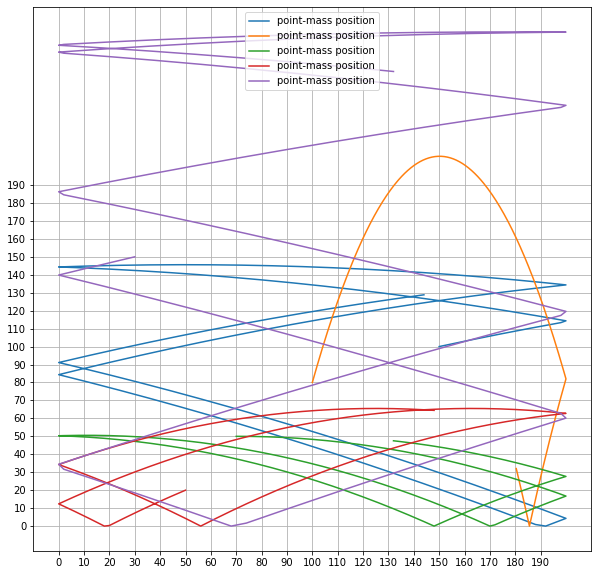

In [48]:
### using 10,000 as SCALE_FP, consistent with cairo contract setup
SCALE_FP = 10000
PRIME = 3618502788666131213697322783095070105623107215331596699973092056135872020481
PRIME_HALF = PRIME//2

def adjust_for_negative (history):
    return [e if e < PRIME_HALF else e-PRIME for e in history]

x1_fp_history = [1500000, 1540000, 1580000, 1620000, 1660000, 1700000, 1740000, 1780000, 1820000, 1860000, 1900000, 1940000, 1980000, 2000000, 1960000, 1920000, 1880000, 1840000, 1800000, 1760000, 1720000, 1680000, 1640000, 1600000, 1560000, 1520000, 1480000, 1440000, 1400000, 1360000, 1320000, 1280000, 1240000, 1200000, 1160000, 1120000, 1080000, 1040000, 1000000, 960000, 920000, 880000, 840000, 800000, 760000, 720000, 680000, 640000, 600000, 560000, 520000, 480000, 440000, 400000, 360000, 320000, 280000, 240000, 200000, 160000, 120000, 80000, 40000, 0, 40000, 80000, 120000, 160000, 200000, 240000, 280000, 320000, 360000, 400000, 440000, 480000, 520000, 560000, 600000, 640000, 680000, 720000, 760000, 800000, 840000, 880000, 920000, 960000, 1000000, 1040000, 1080000, 1120000, 1160000, 1200000, 1240000, 1280000, 1320000, 1360000, 1400000, 1440000, 1480000, 1520000, 1560000, 1600000, 1640000, 1680000, 1720000, 1760000, 1800000, 1840000, 1880000, 1920000, 1960000, 2000000, 1960000, 1920000, 1880000, 1840000, 1800000, 1760000, 1720000, 1680000, 1640000, 1600000, 1560000, 1520000, 1480000, 1440000, 1400000, 1360000, 1320000, 1280000, 1240000, 1200000, 1160000, 1120000, 1080000, 1040000, 1000000, 960000, 920000, 880000, 840000, 800000, 760000, 720000, 680000, 640000, 600000, 560000, 520000, 480000, 440000, 400000, 360000, 320000, 280000, 240000, 200000, 160000, 120000, 80000, 40000, 0, 40000, 80000, 120000, 160000, 200000, 240000, 280000, 320000, 360000, 400000, 440000, 480000, 520000, 560000, 600000, 640000, 680000, 720000, 760000, 800000, 840000, 880000, 920000, 960000, 1000000, 1040000, 1080000, 1120000, 1160000, 1200000, 1240000, 1280000, 1320000, 1360000, 1400000, 1440000, 1480000, 1520000, 1560000, 1600000, 1640000, 1680000, 1720000, 1760000, 1800000, 1840000, 1880000, 1920000, 1960000, 2000000, 1960000, 1920000, 1880000, 1840000, 1800000, 1760000, 1720000, 1680000, 1640000, 1600000, 1560000, 1520000, 1480000, 1440000, 1400000, 1360000, 1320000, 1280000, 1240000, 1200000, 1160000, 1120000, 1080000, 1040000, 1000000, 960000, 920000, 880000, 840000, 800000, 760000, 720000, 680000, 640000, 600000, 560000, 520000, 480000, 440000, 400000, 360000, 320000, 280000, 240000, 200000, 160000, 120000, 80000, 40000, 0, 40000, 80000, 120000, 160000, 200000, 240000, 280000, 320000, 360000, 400000, 440000, 480000, 520000, 560000, 600000, 640000, 680000, 720000, 760000, 800000, 840000, 880000, 920000, 960000, 1000000, 1040000, 1080000, 1120000, 1160000, 1200000, 1240000, 1280000, 1320000, 1360000, 1400000, 1440000]

y1_fp_history = [1000000, 1012000, 1023840, 1035520, 1047040, 1058400, 1069600, 1080640, 1091520, 1102240, 1112800, 1123200, 1133440, 1143520, 1153440, 1163200, 1172800, 1182240, 1191520, 1200640, 1209600, 1218400, 1227040, 1235520, 1243840, 1252000, 1260000, 1267840, 1275520, 1283040, 1290400, 1297600, 1304640, 1311520, 1318240, 1324800, 1331200, 1337440, 1343520, 1349440, 1355200, 1360800, 1366240, 1371520, 1376640, 1381600, 1386400, 1391040, 1395520, 1399840, 1404000, 1408000, 1411840, 1415520, 1419040, 1422400, 1425600, 1428640, 1431520, 1434240, 1436800, 1439200, 1441440, 1443520, 1445440, 1447200, 1448800, 1450240, 1451520, 1452640, 1453600, 1454400, 1455040, 1455520, 1455840, 1456000, 1456000, 1455840, 1455520, 1455040, 1454400, 1453600, 1452640, 1451520, 1450240, 1448800, 1447200, 1445440, 1443520, 1441440, 1439200, 1436800, 1434240, 1431520, 1428640, 1425600, 1422400, 1419040, 1415520, 1411840, 1408000, 1404000, 1399840, 1395520, 1391040, 1386400, 1381600, 1376640, 1371520, 1366240, 1360800, 1355200, 1349440, 1343520, 1337440, 1331200, 1324800, 1318240, 1311520, 1304640, 1297600, 1290400, 1283040, 1275520, 1267840, 1260000, 1252000, 1243840, 1235520, 1227040, 1218400, 1209600, 1200640, 1191520, 1182240, 1172800, 1163200, 1153440, 1143520, 1133440, 1123200, 1112800, 1102240, 1091520, 1080640, 1069600, 1058400, 1047040, 1035520, 1023840, 1012000, 1000000, 987840, 975520, 963040, 950400, 937600, 924640, 911520, 898240, 884800, 871200, 857440, 843520, 829440, 815200, 800800, 786240, 771520, 756640, 741600, 726400, 711040, 695520, 679840, 664000, 648000, 631840, 615520, 599040, 582400, 565600, 548640, 531520, 514240, 496800, 479200, 461440, 443520, 425440, 407200, 388800, 370240, 351520, 332640, 313600, 294400, 275040, 255520, 235840, 216000, 196000, 175840, 155520, 135040, 114400, 93600, 72640, 51520, 30240, 8800, 0, 21600, 43040, 64320, 85440, 106400, 127200, 147840, 168320, 188640, 208800, 228800, 248640, 268320, 287840, 307200, 326400, 345440, 364320, 383040, 401600, 420000, 438240, 456320, 474240, 492000, 509600, 527040, 544320, 561440, 578400, 595200, 611840, 628320, 644640, 660800, 676800, 692640, 708320, 723840, 739200, 754400, 769440, 784320, 799040, 813600, 828000, 842240, 856320, 870240, 884000, 897600, 911040, 924320, 937440, 950400, 963200, 975840, 988320, 1000640, 1012800, 1024800, 1036640, 1048320, 1059840, 1071200, 1082400, 1093440, 1104320, 1115040, 1125600, 1136000, 1146240, 1156320, 1166240, 1176000, 1185600, 1195040, 1204320, 1213440, 1222400, 1231200, 1239840, 1248320, 1256640, 1264800, 1272800, 1280640, 1288320]

x2_fp_history = [1000000, 1004000, 1008000, 1012000, 1016000, 1020000, 1024000, 1028000, 1032000, 1036000, 1040000, 1044000, 1048000, 1052000, 1056000, 1060000, 1064000, 1068000, 1072000, 1076000, 1080000, 1084000, 1088000, 1092000, 1096000, 1100000, 1104000, 1108000, 1112000, 1116000, 1120000, 1124000, 1128000, 1132000, 1136000, 1140000, 1144000, 1148000, 1152000, 1156000, 1160000, 1164000, 1168000, 1172000, 1176000, 1180000, 1184000, 1188000, 1192000, 1196000, 1200000, 1204000, 1208000, 1212000, 1216000, 1220000, 1224000, 1228000, 1232000, 1236000, 1240000, 1244000, 1248000, 1252000, 1256000, 1260000, 1264000, 1268000, 1272000, 1276000, 1280000, 1284000, 1288000, 1292000, 1296000, 1300000, 1304000, 1308000, 1312000, 1316000, 1320000, 1324000, 1328000, 1332000, 1336000, 1340000, 1344000, 1348000, 1352000, 1356000, 1360000, 1364000, 1368000, 1372000, 1376000, 1380000, 1384000, 1388000, 1392000, 1396000, 1400000, 1404000, 1408000, 1412000, 1416000, 1420000, 1424000, 1428000, 1432000, 1436000, 1440000, 1444000, 1448000, 1452000, 1456000, 1460000, 1464000, 1468000, 1472000, 1476000, 1480000, 1484000, 1488000, 1492000, 1496000, 1500000, 1504000, 1508000, 1512000, 1516000, 1520000, 1524000, 1528000, 1532000, 1536000, 1540000, 1544000, 1548000, 1552000, 1556000, 1560000, 1564000, 1568000, 1572000, 1576000, 1580000, 1584000, 1588000, 1592000, 1596000, 1600000, 1604000, 1608000, 1612000, 1616000, 1620000, 1624000, 1628000, 1632000, 1636000, 1640000, 1644000, 1648000, 1652000, 1656000, 1660000, 1664000, 1668000, 1672000, 1676000, 1680000, 1684000, 1688000, 1692000, 1696000, 1700000, 1704000, 1708000, 1712000, 1716000, 1720000, 1724000, 1728000, 1732000, 1736000, 1740000, 1744000, 1748000, 1752000, 1756000, 1760000, 1764000, 1768000, 1772000, 1776000, 1780000, 1784000, 1788000, 1792000, 1796000, 1800000, 1804000, 1808000, 1812000, 1816000, 1820000, 1824000, 1828000, 1832000, 1836000, 1840000, 1844000, 1848000, 1852000, 1856000, 1860000, 1864000, 1868000, 1872000, 1876000, 1880000, 1884000, 1888000, 1892000, 1896000, 1900000, 1904000, 1908000, 1912000, 1916000, 1920000, 1924000, 1928000, 1932000, 1936000, 1940000, 1944000, 1948000, 1952000, 1956000, 1960000, 1964000, 1968000, 1972000, 1976000, 1980000, 1984000, 1988000, 1992000, 1996000, 2000000, 1996000, 1992000, 1988000, 1984000, 1980000, 1976000, 1972000, 1968000, 1964000, 1960000, 1956000, 1952000, 1948000, 1944000, 1940000, 1936000, 1932000, 1928000, 1924000, 1920000, 1916000, 1912000, 1908000, 1904000, 1900000, 1896000, 1892000, 1888000, 1884000, 1880000, 1876000, 1872000, 1868000, 1864000, 1860000, 1856000, 1852000, 1848000, 1844000, 1840000, 1836000, 1832000, 1828000, 1824000, 1820000, 1816000, 1812000, 1808000, 1804000]

y2_fp_history = [800000, 820000, 839840, 859520, 879040, 898400, 917600, 936640, 955520, 974240, 992800, 1011200, 1029440, 1047520, 1065440, 1083200, 1100800, 1118240, 1135520, 1152640, 1169600, 1186400, 1203040, 1219520, 1235840, 1252000, 1268000, 1283840, 1299520, 1315040, 1330400, 1345600, 1360640, 1375520, 1390240, 1404800, 1419200, 1433440, 1447520, 1461440, 1475200, 1488800, 1502240, 1515520, 1528640, 1541600, 1554400, 1567040, 1579520, 1591840, 1604000, 1616000, 1627840, 1639520, 1651040, 1662400, 1673600, 1684640, 1695520, 1706240, 1716800, 1727200, 1737440, 1747520, 1757440, 1767200, 1776800, 1786240, 1795520, 1804640, 1813600, 1822400, 1831040, 1839520, 1847840, 1856000, 1864000, 1871840, 1879520, 1887040, 1894400, 1901600, 1908640, 1915520, 1922240, 1928800, 1935200, 1941440, 1947520, 1953440, 1959200, 1964800, 1970240, 1975520, 1980640, 1985600, 1990400, 1995040, 1999520, 2003840, 2008000, 2012000, 2015840, 2019520, 2023040, 2026400, 2029600, 2032640, 2035520, 2038240, 2040800, 2043200, 2045440, 2047520, 2049440, 2051200, 2052800, 2054240, 2055520, 2056640, 2057600, 2058400, 2059040, 2059520, 2059840, 2060000, 2060000, 2059840, 2059520, 2059040, 2058400, 2057600, 2056640, 2055520, 2054240, 2052800, 2051200, 2049440, 2047520, 2045440, 2043200, 2040800, 2038240, 2035520, 2032640, 2029600, 2026400, 2023040, 2019520, 2015840, 2012000, 2008000, 2003840, 1999520, 1995040, 1990400, 1985600, 1980640, 1975520, 1970240, 1964800, 1959200, 1953440, 1947520, 1941440, 1935200, 1928800, 1922240, 1915520, 1908640, 1901600, 1894400, 1887040, 1879520, 1871840, 1864000, 1856000, 1847840, 1839520, 1831040, 1822400, 1813600, 1804640, 1795520, 1786240, 1776800, 1767200, 1757440, 1747520, 1737440, 1727200, 1716800, 1706240, 1695520, 1684640, 1673600, 1662400, 1651040, 1639520, 1627840, 1616000, 1604000, 1591840, 1579520, 1567040, 1554400, 1541600, 1528640, 1515520, 1502240, 1488800, 1475200, 1461440, 1447520, 1433440, 1419200, 1404800, 1390240, 1375520, 1360640, 1345600, 1330400, 1315040, 1299520, 1283840, 1268000, 1252000, 1235840, 1219520, 1203040, 1186400, 1169600, 1152640, 1135520, 1118240, 1100800, 1083200, 1065440, 1047520, 1029440, 1011200, 992800, 974240, 955520, 936640, 917600, 898400, 879040, 859520, 839840, 820000, 800000, 779840, 759520, 739040, 718400, 697600, 676640, 655520, 634240, 612800, 591200, 569440, 547520, 525440, 503200, 480800, 458240, 435520, 412640, 389600, 366400, 343040, 319520, 295840, 272000, 248000, 223840, 199520, 175040, 150400, 125600, 100640, 75520, 50240, 24800, 0, 25600, 51040, 76320, 101440, 126400, 151200, 175840, 200320, 224640, 248800, 272800, 296640, 320320]

x3_fp_history = [700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000, 1020000, 1040000, 1060000, 1080000, 1100000, 1120000, 1140000, 1160000, 1180000, 1200000, 1220000, 1240000, 1260000, 1280000, 1300000, 1320000, 1340000, 1360000, 1380000, 1400000, 1420000, 1440000, 1460000, 1480000, 1500000, 1520000, 1540000, 1560000, 1580000, 1600000, 1620000, 1640000, 1660000, 1680000, 1700000, 1720000, 1740000, 1760000, 1780000, 1800000, 1820000, 1840000, 1860000, 1880000, 1900000, 1920000, 1940000, 1960000, 1980000, 2000000, 1980000, 1960000, 1940000, 1920000, 1900000, 1880000, 1860000, 1840000, 1820000, 1800000, 1780000, 1760000, 1740000, 1720000, 1700000, 1680000, 1660000, 1640000, 1620000, 1600000, 1580000, 1560000, 1540000, 1520000, 1500000, 1480000, 1460000, 1440000, 1420000, 1400000, 1380000, 1360000, 1340000, 1320000, 1300000, 1280000, 1260000, 1240000, 1220000, 1200000, 1180000, 1160000, 1140000, 1120000, 1100000, 1080000, 1060000, 1040000, 1020000, 1000000, 980000, 960000, 940000, 920000, 900000, 880000, 860000, 840000, 820000, 800000, 780000, 760000, 740000, 720000, 700000, 680000, 660000, 640000, 620000, 600000, 580000, 560000, 540000, 520000, 500000, 480000, 460000, 440000, 420000, 400000, 380000, 360000, 340000, 320000, 300000, 280000, 260000, 240000, 220000, 200000, 180000, 160000, 140000, 120000, 100000, 80000, 60000, 40000, 20000, 0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000, 400000, 420000, 440000, 460000, 480000, 500000, 520000, 540000, 560000, 580000, 600000, 620000, 640000, 660000, 680000, 700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000, 1020000, 1040000, 1060000, 1080000, 1100000, 1120000, 1140000, 1160000, 1180000, 1200000, 1220000, 1240000, 1260000, 1280000, 1300000, 1320000, 1340000, 1360000, 1380000, 1400000, 1420000, 1440000, 1460000, 1480000, 1500000, 1520000, 1540000, 1560000, 1580000, 1600000, 1620000, 1640000, 1660000, 1680000, 1700000, 1720000, 1740000, 1760000, 1780000, 1800000, 1820000, 1840000, 1860000, 1880000, 1900000, 1920000, 1940000, 1960000, 1980000, 2000000, 1980000, 1960000, 1940000, 1920000, 1900000, 1880000, 1860000, 1840000, 1820000, 1800000, 1780000, 1760000, 1740000, 1720000, 1700000, 1680000, 1660000, 1640000, 1620000, 1600000, 1580000, 1560000, 1540000, 1520000, 1500000, 1480000, 1460000, 1440000, 1420000, 1400000, 1380000, 1360000, 1340000, 1320000]

y3_fp_history = [500000, 500000, 499840, 499520, 499040, 498400, 497600, 496640, 495520, 494240, 492800, 491200, 489440, 487520, 485440, 483200, 480800, 478240, 475520, 472640, 469600, 466400, 463040, 459520, 455840, 452000, 448000, 443840, 439520, 435040, 430400, 425600, 420640, 415520, 410240, 404800, 399200, 393440, 387520, 381440, 375200, 368800, 362240, 355520, 348640, 341600, 334400, 327040, 319520, 311840, 304000, 296000, 287840, 279520, 271040, 262400, 253600, 244640, 235520, 226240, 216800, 207200, 197440, 187520, 177440, 167200, 156800, 146240, 135520, 124640, 113600, 102400, 91040, 79520, 67840, 56000, 44000, 31840, 19520, 7040, 0, 12640, 25120, 37440, 49600, 61600, 73440, 85120, 96640, 108000, 119200, 130240, 141120, 151840, 162400, 172800, 183040, 193120, 203040, 212800, 222400, 231840, 241120, 250240, 259200, 268000, 276640, 285120, 293440, 301600, 309600, 317440, 325120, 332640, 340000, 347200, 354240, 361120, 367840, 374400, 380800, 387040, 393120, 399040, 404800, 410400, 415840, 421120, 426240, 431200, 436000, 440640, 445120, 449440, 453600, 457600, 461440, 465120, 468640, 472000, 475200, 478240, 481120, 483840, 486400, 488800, 491040, 493120, 495040, 496800, 498400, 499840, 501120, 502240, 503200, 504000, 504640, 505120, 505440, 505600, 505600, 505440, 505120, 504640, 504000, 503200, 502240, 501120, 499840, 498400, 496800, 495040, 493120, 491040, 488800, 486400, 483840, 481120, 478240, 475200, 472000, 468640, 465120, 461440, 457600, 453600, 449440, 445120, 440640, 436000, 431200, 426240, 421120, 415840, 410400, 404800, 399040, 393120, 387040, 380800, 374400, 367840, 361120, 354240, 347200, 340000, 332640, 325120, 317440, 309600, 301600, 293440, 285120, 276640, 268000, 259200, 250240, 241120, 231840, 222400, 212800, 203040, 193120, 183040, 172800, 162400, 151840, 141120, 130240, 119200, 108000, 96640, 85120, 73440, 61600, 49600, 37440, 25120, 12640, 0, 12640, 25120, 37440, 49600, 61600, 73440, 85120, 96640, 108000, 119200, 130240, 141120, 151840, 162400, 172800, 183040, 193120, 203040, 212800, 222400, 231840, 241120, 250240, 259200, 268000, 276640, 285120, 293440, 301600, 309600, 317440, 325120, 332640, 340000, 347200, 354240, 361120, 367840, 374400, 380800, 387040, 393120, 399040, 404800, 410400, 415840, 421120, 426240, 431200, 436000, 440640, 445120, 449440, 453600, 457600, 461440, 465120, 468640, 472000, 475200]

x4_fp_history = [500000, 480000, 460000, 440000, 420000, 400000, 380000, 360000, 340000, 320000, 300000, 280000, 260000, 240000, 220000, 200000, 180000, 160000, 140000, 120000, 100000, 80000, 60000, 40000, 20000, 0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000, 400000, 420000, 440000, 460000, 480000, 500000, 520000, 540000, 560000, 580000, 600000, 620000, 640000, 660000, 680000, 700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000, 1020000, 1040000, 1060000, 1080000, 1100000, 1120000, 1140000, 1160000, 1180000, 1200000, 1220000, 1240000, 1260000, 1280000, 1300000, 1320000, 1340000, 1360000, 1380000, 1400000, 1420000, 1440000, 1460000, 1480000, 1500000, 1520000, 1540000, 1560000, 1580000, 1600000, 1620000, 1640000, 1660000, 1680000, 1700000, 1720000, 1740000, 1760000, 1780000, 1800000, 1820000, 1840000, 1860000, 1880000, 1900000, 1920000, 1940000, 1960000, 1980000, 2000000, 1980000, 1960000, 1940000, 1920000, 1900000, 1880000, 1860000, 1840000, 1820000, 1800000, 1780000, 1760000, 1740000, 1720000, 1700000, 1680000, 1660000, 1640000, 1620000, 1600000, 1580000, 1560000, 1540000, 1520000, 1500000, 1480000, 1460000, 1440000, 1420000, 1400000, 1380000, 1360000, 1340000, 1320000, 1300000, 1280000, 1260000, 1240000, 1220000, 1200000, 1180000, 1160000, 1140000, 1120000, 1100000, 1080000, 1060000, 1040000, 1020000, 1000000, 980000, 960000, 940000, 920000, 900000, 880000, 860000, 840000, 820000, 800000, 780000, 760000, 740000, 720000, 700000, 680000, 660000, 640000, 620000, 600000, 580000, 560000, 540000, 520000, 500000, 480000, 460000, 440000, 420000, 400000, 380000, 360000, 340000, 320000, 300000, 280000, 260000, 240000, 220000, 200000, 180000, 160000, 140000, 120000, 100000, 80000, 60000, 40000, 20000, 0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000, 300000, 320000, 340000, 360000, 380000, 400000, 420000, 440000, 460000, 480000, 500000, 520000, 540000, 560000, 580000, 600000, 620000, 640000, 660000, 680000, 700000, 720000, 740000, 760000, 780000, 800000, 820000, 840000, 860000, 880000, 900000, 920000, 940000, 960000, 980000, 1000000, 1020000, 1040000, 1060000, 1080000, 1100000, 1120000, 1140000, 1160000, 1180000, 1200000, 1220000, 1240000, 1260000, 1280000, 1300000, 1320000, 1340000, 1360000, 1380000, 1400000, 1420000, 1440000, 1460000, 1480000]

y4_fp_history = [200000, 188000, 175840, 163520, 151040, 138400, 125600, 112640, 99520, 86240, 72800, 59200, 45440, 31520, 17440, 3200, 0, 14400, 28640, 42720, 56640, 70400, 84000, 97440, 110720, 123840, 136800, 149600, 162240, 174720, 187040, 199200, 211200, 223040, 234720, 246240, 257600, 268800, 279840, 290720, 301440, 312000, 322400, 332640, 342720, 352640, 362400, 372000, 381440, 390720, 399840, 408800, 417600, 426240, 434720, 443040, 451200, 459200, 467040, 474720, 482240, 489600, 496800, 503840, 510720, 517440, 524000, 530400, 536640, 542720, 548640, 554400, 560000, 565440, 570720, 575840, 580800, 585600, 590240, 594720, 599040, 603200, 607200, 611040, 614720, 618240, 621600, 624800, 627840, 630720, 633440, 636000, 638400, 640640, 642720, 644640, 646400, 648000, 649440, 650720, 651840, 652800, 653600, 654240, 654720, 655040, 655200, 655200, 655040, 654720, 654240, 653600, 652800, 651840, 650720, 649440, 648000, 646400, 644640, 642720, 640640, 638400, 636000, 633440, 630720, 627840, 624800, 621600, 618240, 614720, 611040, 607200, 603200, 599040, 594720, 590240, 585600, 580800, 575840, 570720, 565440, 560000, 554400, 548640, 542720, 536640, 530400, 524000, 517440, 510720, 503840, 496800, 489600, 482240, 474720, 467040, 459200, 451200, 443040, 434720, 426240, 417600, 408800, 399840, 390720, 381440, 372000, 362400, 352640, 342720, 332640, 322400, 312000, 301440, 290720, 279840, 268800, 257600, 246240, 234720, 223040, 211200, 199200, 187040, 174720, 162240, 149600, 136800, 123840, 110720, 97440, 84000, 70400, 56640, 42720, 28640, 14400, 0, 14400, 28640, 42720, 56640, 70400, 84000, 97440, 110720, 123840, 136800, 149600, 162240, 174720, 187040, 199200, 211200, 223040, 234720, 246240, 257600, 268800, 279840, 290720, 301440, 312000, 322400, 332640, 342720, 352640, 362400, 372000, 381440, 390720, 399840, 408800, 417600, 426240, 434720, 443040, 451200, 459200, 467040, 474720, 482240, 489600, 496800, 503840, 510720, 517440, 524000, 530400, 536640, 542720, 548640, 554400, 560000, 565440, 570720, 575840, 580800, 585600, 590240, 594720, 599040, 603200, 607200, 611040, 614720, 618240, 621600, 624800, 627840, 630720, 633440, 636000, 638400, 640640, 642720, 644640, 646400, 648000, 649440, 650720, 651840, 652800, 653600, 654240, 654720, 655040, 655200, 655200, 655040, 654720, 654240, 653600, 652800, 651840, 650720, 649440, 648000, 646400, 644640]

x5_fp_history = [300000, 240000, 180000, 120000, 60000, 0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000, 1380000, 1440000, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2000000, 1940000, 1880000, 1820000, 1760000, 1700000, 1640000, 1580000, 1520000, 1460000, 1400000, 1340000, 1280000, 1220000, 1160000, 1100000, 1040000, 980000, 920000, 860000, 800000, 740000, 680000, 620000, 560000, 500000, 440000, 380000, 320000, 260000, 200000, 140000, 80000, 20000, 0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000, 1380000, 1440000, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2000000, 1940000, 1880000, 1820000, 1760000, 1700000, 1640000, 1580000, 1520000, 1460000, 1400000, 1340000, 1280000, 1220000, 1160000, 1100000, 1040000, 980000, 920000, 860000, 800000, 740000, 680000, 620000, 560000, 500000, 440000, 380000, 320000, 260000, 200000, 140000, 80000, 20000, 0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000, 1380000, 1440000, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2000000, 1940000, 1880000, 1820000, 1760000, 1700000, 1640000, 1580000, 1520000, 1460000, 1400000, 1340000, 1280000, 1220000, 1160000, 1100000, 1040000, 980000, 920000, 860000, 800000, 740000, 680000, 620000, 560000, 500000, 440000, 380000, 320000, 260000, 200000, 140000, 80000, 20000, 0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000, 1380000, 1440000, 1500000, 1560000, 1620000, 1680000, 1740000, 1800000, 1860000, 1920000, 1980000, 2000000, 1940000, 1880000, 1820000, 1760000, 1700000, 1640000, 1580000, 1520000, 1460000, 1400000, 1340000, 1280000, 1220000, 1160000, 1100000, 1040000, 980000, 920000, 860000, 800000, 740000, 680000, 620000, 560000, 500000, 440000, 380000, 320000, 260000, 200000, 140000, 80000, 20000, 0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000, 540000, 600000, 660000, 720000, 780000, 840000, 900000, 960000, 1020000, 1080000, 1140000, 1200000, 1260000, 1320000]

y5_fp_history = [1500000, 1480000, 1459840, 1439520, 1419040, 1398400, 1377600, 1356640, 1335520, 1314240, 1292800, 1271200, 1249440, 1227520, 1205440, 1183200, 1160800, 1138240, 1115520, 1092640, 1069600, 1046400, 1023040, 999520, 975840, 952000, 928000, 903840, 879520, 855040, 830400, 805600, 780640, 755520, 730240, 704800, 679200, 653440, 627520, 601440, 575200, 548800, 522240, 495520, 468640, 441600, 414400, 387040, 359520, 331840, 304000, 276000, 247840, 219520, 191040, 162400, 133600, 104640, 75520, 46240, 16800, 0, 29600, 59040, 88320, 117440, 146400, 175200, 203840, 232320, 260640, 288800, 316800, 344640, 372320, 399840, 427200, 454400, 481440, 508320, 535040, 561600, 588000, 614240, 640320, 666240, 692000, 717600, 743040, 768320, 793440, 818400, 843200, 867840, 892320, 916640, 940800, 964800, 988640, 1012320, 1035840, 1059200, 1082400, 1105440, 1128320, 1151040, 1173600, 1196000, 1218240, 1240320, 1262240, 1284000, 1305600, 1327040, 1348320, 1369440, 1390400, 1411200, 1431840, 1452320, 1472640, 1492800, 1512800, 1532640, 1552320, 1571840, 1591200, 1610400, 1629440, 1648320, 1667040, 1685600, 1704000, 1722240, 1740320, 1758240, 1776000, 1793600, 1811040, 1828320, 1845440, 1862400, 1879200, 1895840, 1912320, 1928640, 1944800, 1960800, 1976640, 1992320, 2007840, 2023200, 2038400, 2053440, 2068320, 2083040, 2097600, 2112000, 2126240, 2140320, 2154240, 2168000, 2181600, 2195040, 2208320, 2221440, 2234400, 2247200, 2259840, 2272320, 2284640, 2296800, 2308800, 2320640, 2332320, 2343840, 2355200, 2366400, 2377440, 2388320, 2399040, 2409600, 2420000, 2430240, 2440320, 2450240, 2460000, 2469600, 2479040, 2488320, 2497440, 2506400, 2515200, 2523840, 2532320, 2540640, 2548800, 2556800, 2564640, 2572320, 2579840, 2587200, 2594400, 2601440, 2608320, 2615040, 2621600, 2628000, 2634240, 2640320, 2646240, 2652000, 2657600, 2663040, 2668320, 2673440, 2678400, 2683200, 2687840, 2692320, 2696640, 2700800, 2704800, 2708640, 2712320, 2715840, 2719200, 2722400, 2725440, 2728320, 2731040, 2733600, 2736000, 2738240, 2740320, 2742240, 2744000, 2745600, 2747040, 2748320, 2749440, 2750400, 2751200, 2751840, 2752320, 2752640, 2752800, 2752800, 2752640, 2752320, 2751840, 2751200, 2750400, 2749440, 2748320, 2747040, 2745600, 2744000, 2742240, 2740320, 2738240, 2736000, 2733600, 2731040, 2728320, 2725440, 2722400, 2719200, 2715840, 2712320, 2708640, 2704800, 2700800, 2696640, 2692320, 2687840, 2683200, 2678400, 2673440, 2668320, 2663040, 2657600, 2652000, 2646240, 2640320, 2634240, 2628000, 2621600, 2615040, 2608320, 2601440, 2594400, 2587200, 2579840, 2572320, 2564640, 2556800, 2548800, 2540640, 2532320]

total_n = len(x1_fp_history)

x1_history = [x/SCALE_FP for x in x1_fp_history]
y1_history = [y/SCALE_FP for y in y1_fp_history]
x2_history = [x/SCALE_FP for x in x2_fp_history]
y2_history = [y/SCALE_FP for y in y2_fp_history]
x3_history = [x/SCALE_FP for x in x3_fp_history]
y3_history = [y/SCALE_FP for y in y3_fp_history]
x4_history = [x/SCALE_FP for x in x4_fp_history]
y4_history = [y/SCALE_FP for y in y4_fp_history]
x5_history = [x/SCALE_FP for x in x5_fp_history]
y5_history = [y/SCALE_FP for y in y5_fp_history]

fig, ax = plt.subplots(1,1,figsize=(10,10))

view_n = total_n
#ax.scatter(x_history[0:view_n], y_history[0:view_n], color='C0', s=3, label='point-mass position')
ax.plot(x1_history[0:view_n], y1_history[0:view_n], color='C0', label='point-mass position')
ax.plot(x2_history[0:view_n], y2_history[0:view_n], color='C1', label='point-mass position')
ax.plot(x3_history[0:view_n], y3_history[0:view_n], color='C2', label='point-mass position')
ax.plot(x4_history[0:view_n], y4_history[0:view_n], color='C3', label='point-mass position')
ax.plot(x5_history[0:view_n], y5_history[0:view_n], color='C4', label='point-mass position')

ax.legend(loc="upper center")
plt.xticks(np.arange(0, 200, 10))
plt.yticks(np.arange(0, 200, 10))
plt.grid()

# eyeball confirm the plot matches simulation above